# Auto Encoders

At it's core, an autoencoder is a function that takes complex inputs and performs a dimensionality reduction of the data.  Principal Component Analysis is an example of a classical encoding algorithm.  Even a simple linear regression in 2D can serve as an encoder, since you map 2 dimensions (x and y) into just one dimension (position along a line).

An important feature of autoencoders is the ability to reconstruct the input data from the compressed feature representation.  It's easy to see how this is done when you have used PCA or linear regression, but it is more complex with a neural network.

One advantage of using neural networks as auto-encoders is that they have capacity to encode complex data, and the training regime for encoding is not overly complex and similar for many types of data.

In this notebook, we will build an autoencoder for handwritten digits between 0 and 99, inclusive, generated via the mnist dataset.

In [3]:
# Load numpy and tensorflow:

import tensorflow as tf
import numpy
import random

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, clear_output





In [4]:
# Use TF to get the dataset, will download if needed.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(numpy.float32) * (1./256)
x_test  = x_test.astype(numpy.float32) * (1./256)

Auto Encoders do a really good job at taking input, compressing it into a small latent vector, and then decoding that back into the original image.  But, it has some downsides.  Let's demonstrate this with a simple convolutional auto encoder on MNIST data.  This is based off of a resnet architecture, but a lot smaller:

In [5]:
class ResBlock(tf.keras.models.Model):
    
    '''
    Residual block with configurable activation
    '''
    
    def __init__(self, n_filters, activation=tf.nn.relu):
        tf.keras.models.Model.__init__(self)

        self.convolution1 = tf.keras.layers.Convolution2D(
            kernel_size = [3, 3], 
            filters     = n_filters,
            padding     = "same",
            activation  = None,
        )
        
        self.convolution2 = tf.keras.layers.Convolution2D(
            kernel_size = [3, 3], 
            filters     = n_filters,
            padding     = "same",
            activation  = None,
        )
        
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.batch_norm2 = tf.keras.layers.BatchNormalization()


        self.activation = activation
        
    def call(self, inputs):
        
        # Conv 1
        x = self.convolution1(inputs)
        x = self.batch_norm1(x)
        x = self.activation(x)
        
        # Conv2
        x = self.convolution2(x)
        
        x = self.batch_norm2(x)
        
        # Sum:
        x = x + inputs 
        
        x = self.activation(x)
        
        return x

In [6]:
class ConvolutionalEncoder(tf.keras.models.Model):
    '''
    Simple autoencoder forward layer
    '''
    
    def __init__(self, activation=tf.nn.relu, latent_size = 10):
        tf.keras.models.Model.__init__(self)
        self._latent_size = latent_size

        # Apply a 5x5 kernel to the image:
        self.encoder_layer_1 = ResBlock(activation=activation, n_filters=64)
        
        # Use a 2x2 kernel of stride 2x2 to downsample:
        self.pool_1 = tf.keras.layers.MaxPool2D()
        
        self.encoder_layer_2 = ResBlock(activation=activation, n_filters=64)
        self.pool_2 = tf.keras.layers.MaxPool2D()
        
        self.encoder_layer_3 = ResBlock(activation=activation, n_filters=64)
        self.pool_3 = tf.keras.layers.MaxPool2D()

        self.encoder_layer_final = tf.keras.layers.Dense(
            units = latent_size,
            activation = None,
            )
        
        
        


    def call(self, inputs):
        
        batch_size = inputs.shape[0]
        x = inputs
        # Make sure the input is the right shape:
        x = tf.reshape(x, [batch_size, 28, 28, 1])
            
        x = self.encoder_layer_1(x)
        x = self.pool_1(x)
        x = self.encoder_layer_2(x)
        x = self.pool_2(x)
        x = self.encoder_layer_3(x)
        x = self.pool_3(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.encoder_layer_final(x)
        return tf.reshape(x, [batch_size, self._latent_size])



In [13]:
class ConvolutionalDecoder(tf.keras.models.Model):
    
    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        # The decoder runs the encoder steps but in reverse.
        
        # The first step is a dense layer to get to the right number of units.
        # It turns out to need to be of shape [3, 3]
        self.dense = tf.keras.layers.Dense(
            units = 3 * 3 * 64
        )
        
        
        self.decoder_layer_1 = ResBlock(n_filters=64, activation=activation)
        
        self.unpool_1 = tf.keras.layers.UpSampling2D(
            size          = 2,
            interpolation = "nearest",
        )

        self.decoder_layer_2 = ResBlock(n_filters=64, activation=activation)
        
        self.unpool_2 = tf.keras.layers.UpSampling2D(
            size          = 2,
            interpolation = "nearest",
        )


        self.decoder_layer_3 = ResBlock(n_filters=64, activation=activation)
        
        self.decoder_layer_final = tf.keras.layers.Convolution2D(
            kernel_size = [1, 1],
            filters     = 1,
            padding     = "same",
            use_bias    = True,
            kernel_regularizer = tf.keras.regularizers.L2(),
            activation  = None,
        )
        

        
    def call(self, inputs):
        ''' 
        Reshape at input and output: 
        '''
            
        
        batch_size = inputs.shape[0]


        x = self.dense(inputs)


        # First Step is to to un-pool the encoded state into the right shape:
        x = tf.reshape(x, [batch_size, 3, 3, 64])
        x = tf.image.resize(
            x,
            size=[7,7]
        )
        
        x = self.decoder_layer_1(x)
        x = self.unpool_1(x)
        x = self.decoder_layer_2(x)
        x = self.unpool_2(x)
        x = self.decoder_layer_3(x)
        x = self.decoder_layer_final(x)

        x = tf.nn.sigmoid(x)
        
        x = tf.reshape(x, [batch_size, 28, 28, 1])
        return x

Let's initialize an instance of each of these networks and do a forward pass:

In [14]:
encoder = ConvolutionalEncoder(latent_size=20)
decoder = ConvolutionalDecoder()
test_input = x_train[0].reshape([1,28,28,1])

intermediate_state = encoder(test_input)
decoded_image = decoder(intermediate_state)

Let's inspect the layers of the models:


In [15]:
print(encoder.summary())

Model: "convolutional_encoder_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
res_block_18 (ResBlock)      multiple                  38080     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 multiple                  0         
_________________________________________________________________
res_block_19 (ResBlock)      multiple                  74368     
_________________________________________________________________
max_pooling2d_10 (MaxPooling multiple                  0         
_________________________________________________________________
res_block_20 (ResBlock)      multiple                  74368     
_________________________________________________________________
max_pooling2d_11 (MaxPooling multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple      

In [16]:
print(decoder.summary())

Model: "convolutional_decoder_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              multiple                  12096     
_________________________________________________________________
res_block_21 (ResBlock)      multiple                  74368     
_________________________________________________________________
up_sampling2d_6 (UpSampling2 multiple                  0         
_________________________________________________________________
res_block_22 (ResBlock)      multiple                  74368     
_________________________________________________________________
up_sampling2d_7 (UpSampling2 multiple                  0         
_________________________________________________________________
res_block_23 (ResBlock)      multiple                  74368     
_________________________________________________________________
conv2d_49 (Conv2D)           multiple      

What does the intermediate state and decoded images look like?


tf.Tensor(
[[-0.5596386  -3.0443292  -1.1392884  -2.8217807   0.18638748  3.847396
  -1.0116516   0.42142302  1.6642435   1.3152697   2.1922827   0.4196825
  -0.9409023   0.720794   -0.5824955   1.378108   -1.5909659   0.24505621
   1.1379395  -0.30629548]], shape=(1, 20), dtype=float32)


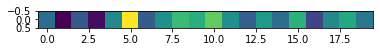

In [17]:
print(intermediate_state)
plt.imshow(intermediate_state)

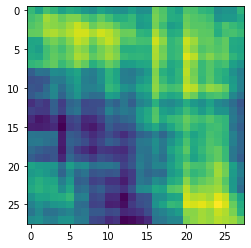

In [18]:
# And here is the output image:
decoded_images_reshape = decoded_image.numpy().reshape(28, 28)
plt.imshow(decoded_images_reshape)

Unsuprisingly, this is just empty noise.

# Training an Autoencoder

With a trained encoder/decoder pair, we want the input image to be as close as possible to the output image.  The loss for this network, then, can be constructed as just the mean-square-error of input to output.  We will train this with an AdamOptimizer.

In [19]:
# These parameters control the training behavior: batch size and how many iterations to use
BATCH_SIZE=64
N_EPOCHS=2

[0.0, 0.0010666666666666667, 0.0021333333333333334, 0.0032, 0.004266666666666667, 0.005333333333333333, 0.0064, 0.007466666666666667, 0.008533333333333334, 0.0096, 0.010666666666666666, 0.011733333333333333, 0.0128, 0.013866666666666666, 0.014933333333333333, 0.016, 0.017066666666666667, 0.018133333333333335, 0.0192, 0.020266666666666665, 0.021333333333333333, 0.0224, 0.023466666666666667, 0.024533333333333334, 0.0256, 0.02666666666666667, 0.027733333333333332, 0.0288, 0.029866666666666666, 0.030933333333333334, 0.032, 0.03306666666666667, 0.034133333333333335, 0.0352, 0.03626666666666667, 0.037333333333333336, 0.0384, 0.039466666666666664, 0.04053333333333333, 0.0416, 0.042666666666666665, 0.04373333333333333, 0.0448, 0.04586666666666667, 0.046933333333333334, 0.048, 0.04906666666666667, 0.050133333333333335, 0.0512, 0.05226666666666667, 0.05333333333333334, 0.0544, 0.055466666666666664, 0.05653333333333333, 0.0576, 0.058666666666666666, 0.05973333333333333, 0.0608, 0.0618666666666666

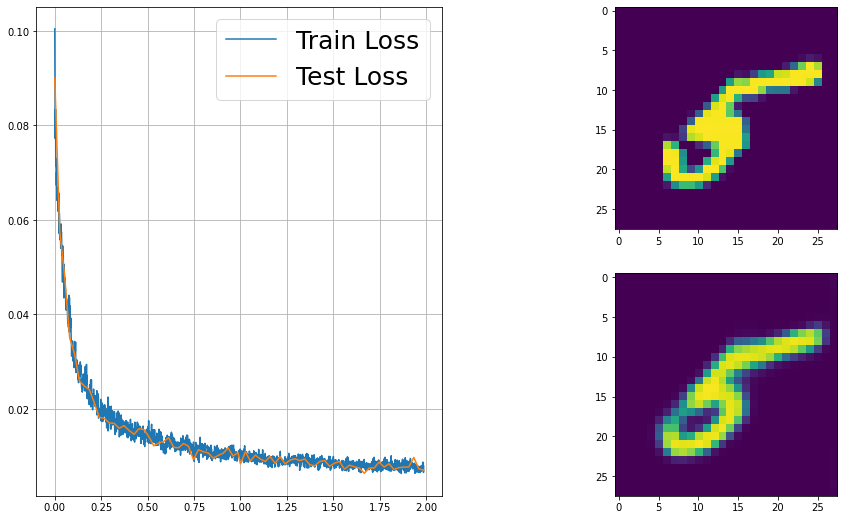

In [27]:
optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.MeanSquaredError()

# We will keep track of loss along the way:
steps = []
loss_history = []
val_loss_history = []
val_steps = []

# Define a figure here which we can update along the way:
fig       = plt.figure(figsize=(16,9))
# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)
ax_loss   = plt.subplot(gs[:,0])
ax_input  = plt.subplot(gs[0,1])
ax_output = plt.subplot(gs[1,1])


for e in range(N_EPOCHS):
    
    # First, shuffle the training data:
    numpy.random.shuffle(x_train)
    
    # Now, loop over the data in batches:
    for batch in range(int(60000/BATCH_SIZE)):
    
        # Variable for plotting:
        epoch_value = e + (batch*BATCH_SIZE)/60000
    
        # Load some data:
        batch_images = x_train[batch*BATCH_SIZE : (batch+1)*BATCH_SIZE]
        # Reshape the data:
        batch_images = batch_images.reshape([BATCH_SIZE, 28,28,1])
        with tf.GradientTape() as tape:
            intermediate_state = encoder(batch_images)
            decoded_images = decoder(intermediate_state)
            loss_value = loss_function(batch_images, decoded_images)
        
        # Collect the trainable variables as the union of the encoder and decoder variables:
        trainable_vars = encoder.trainable_variables + decoder.trainable_variables

        # Update the loss history:
        loss_history.append(loss_value.numpy())
        steps.append(epoch_value)

        # Apply the update to the model:
        grads = tape.gradient(loss_value, trainable_vars)
        optimizer.apply_gradients(zip(grads, trainable_vars))


            
        if batch % 25 == 0:
            test_indexes = numpy.random.choice(range(10000), size=BATCH_SIZE)
            test_images = x_test[test_indexes]
            test_images = test_images.reshape([BATCH_SIZE, 28,28,1])
            val_intermediate_state = encoder(test_images)
            val_decoded_images = decoder(val_intermediate_state)
            val_loss_value = loss_function(test_images, val_decoded_images)
            val_loss_history.append(val_loss_value.numpy())
            val_steps.append(epoch_value)

            # Here we update the plots.  Replot the loss, and show the latest input and output images
            ax_loss.set_xlim(0, 1.1*epoch_value)
            ax_loss.cla()
            ax_loss.plot(steps, loss_history, label="Train Loss")
            ax_loss.plot(val_steps, val_loss_history, label="Test Loss")
            ax_loss.grid(True)
            ax_loss.legend(fontsize=25)

            # Display an input image:
            ax_input.imshow(batch_images[0].reshape(28, 28),vmin=0, vmax=1)

            # Display an output image:
            ax_output.imshow(decoded_images.numpy()[0].reshape(28, 28),vmin=0, vmax=1)

            display(fig)
            clear_output(wait = True)
            plt.pause(0.25)

        
# Let's save the models weights as well:
encoder.save_weights("encoder_basic.h5")
decoder.save_weights("decoder_basic.h5")


In [28]:
# # If you don't want or don't have time to train, you can preload the models:
# encoder.load_weights("saved_networks/encoder_basic.h5")
# decoder.load_weights("saved_networks/decoder_basic.h5")

This autoencoder is doing great, you should have pretty good results after just half an epoch.


# What can you do with Auto Encoders?

## Application: Data Compression

In principle, auto encoders are good for data compression:  its like non-linear PCA.  But you can do more than just compression, as well.  In order to decode an image, the latent state ought to contain just about all of the information that is important to that image.  So, you could take the latent states directly and use them to classify digits.

To demonstrate this, let's use a small classifier network:

In [30]:
class SimpleClassifier(tf.keras.models.Model):
    
    '''
    Very simple classifier for latent space to mnist classification
    '''
    
    def __init__(self):
        tf.keras.models.Model.__init__(self)

        self.dense = tf.keras.layers.Dense(
            units = 10, 
        )

        
    def call(self, inputs):
        
        return self.dense(inputs)

In [31]:
classifier = SimpleClassifier()

classification = classifier(intermediate_state)

print(classifier.summary())

Model: "simple_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              multiple                  210       
Total params: 210
Trainable params: 210
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
# Reloading the dataset here to make sure it's shuffled properly
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(numpy.float32) * (1./256)
x_test  = x_test.astype(numpy.float32) * (1./256)
y_train = y_train.astype(numpy.int64)
y_test  = y_test.astype(numpy.int64)

In [33]:
N_EPOCHS=2
BATCH_SIZE=64

In [37]:
optimizer = tf.keras.optimizers.Adam()
loss_func = tf.losses.SparseCategoricalCrossentropy()

# We will keep track of loss along the way:
classifier_steps = []
classifier_loss_history = []
classifier_acc_history = []
classifier_test_loss_history = []
classifier_test_steps = []
classifier_test_acc_history = []


# Define a figure here which we can update along the way:
fig       = plt.figure(figsize=(16,9))
# Create 2x2 sub plot
gs = gridspec.GridSpec(1,2)
ax_loss   = plt.subplot(gs[0,0])
ax_acc    = plt.subplot(gs[0,1])


for e in range(N_EPOCHS):
    
    # First, shuffle the training data:
    indexes = numpy.arange(len(x_train))
    numpy.random.shuffle(indexes)
    
    # Now, loop over the data in batches:
    for batch in range(int(60000/BATCH_SIZE)):
    
        # Variable for plotting:
        epoch_value = e + (batch*BATCH_SIZE)/60000
    
        batch_index = indexes[batch*BATCH_SIZE:(batch+1)*BATCH_SIZE]
        # Load some data:
        batch_images = x_train[batch_index]
        batch_labels = y_train[batch_index]
        # Reshape the data:
        batch_images = batch_images.reshape([BATCH_SIZE, 28,28,1])
        with tf.GradientTape() as tape:
            intermediate_state = encoder(batch_images)
            classification = classifier(intermediate_state)

            loss_value = loss_func(y_true=batch_labels, y_pred=classification)
            prediction = tf.argmax(classification, axis=-1)
            accuracy = numpy.mean(prediction.numpy() == batch_labels)
        # Collect the trainable variables of just the classifier:
        trainable_vars = classifier.trainable_variables

        # Update the loss history:
        classifier_loss_history.append(loss_value.numpy())
        classifier_acc_history.append(accuracy)
        classifier_steps.append(epoch_value)

        # Apply the update to the model:
        grads = tape.gradient(loss_value, trainable_vars)
        optimizer.apply_gradients(zip(grads, trainable_vars))


            
        if batch % 25 == 0:
            test_indexes = numpy.random.choice(range(10000), size=BATCH_SIZE)
            test_images = x_test[test_indexes]
            test_label  = y_test[test_indexes]
            test_images = test_images.reshape([BATCH_SIZE, 28,28,1])
            test_intermediate_state = encoder(test_images)
            test_classification = classifier(test_intermediate_state)
            test_loss_value = loss_func(y_true=test_label, y_pred=test_classification)
            test_prediction = tf.argmax(test_classification, axis=-1)
            test_accuracy = numpy.mean(test_prediction.numpy() == test_label)
            classifier_test_loss_history.append(test_loss_value.numpy())
            classifier_test_steps.append(epoch_value)
            classifier_test_acc_history.append(accuracy)


            # Here we update the plots.  Replot the loss and accuracy
            ax_loss.set_xlim(0, 1.1*epoch_value)
            ax_loss.cla()
            ax_loss.plot(classifier_steps, classifier_loss_history, label="Train Loss")
            ax_loss.plot(classifier_test_steps, classifier_test_loss_history, label="Test Loss")
            ax_loss.grid(True)
            ax_loss.legend(fontsize=25)
            
            ax_acc.set_xlim(0, 1.1*epoch_value)
            ax_acc.set_ylim(0, 1.0)
            ax_acc.cla()
            ax_acc.plot(classifier_steps, classifier_acc_history, label="Train Acc.")
            ax_acc.plot(classifier_test_steps, classifier_test_acc_history, label="Test Acc.")
            ax_acc.grid(True)
            ax_acc.legend(fontsize=25)
            
            display(fig)
            clear_output(wait = True)
            plt.pause(0.25)

        
# Let's save the models weights as well:
classifier.save_weights("classifier.h5")



KeyboardInterrupt: 

As you can see, the accuracy increased to good levels (> 90%) on both the train and test sets.  This classifier we're training has only 210 parameters!  Clearly, the intermediate state has a lot of information for discriminating the class available.

## Image interpolation

The latent space is not "continuous" in real numbers.  That is, taking two latent vectors and decoding them, and all the numbers in between them, does not produce a suite of real and believable images.  Instead, it slowly transforms one number into the other.

In [38]:
latent_vec = encoder(x_test)

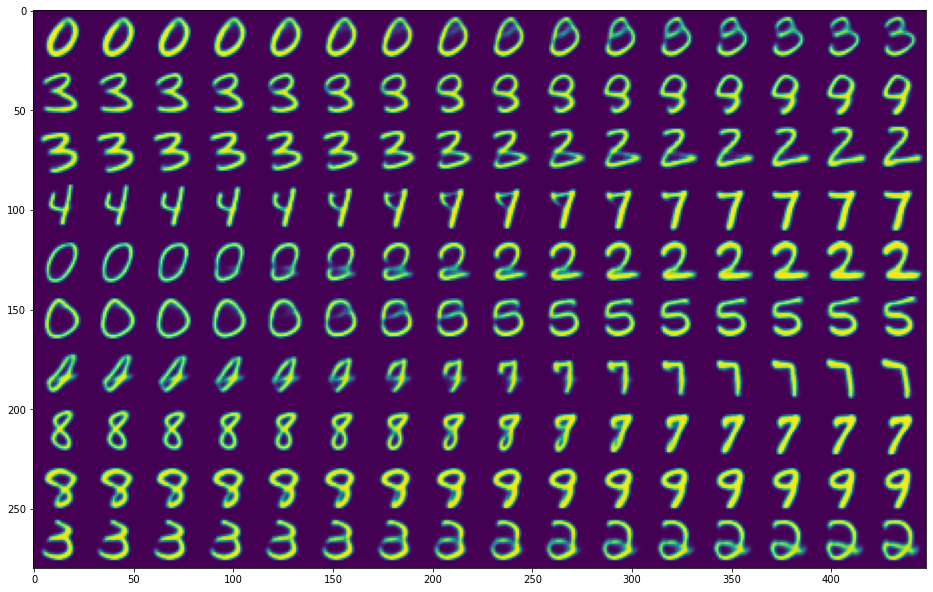

In [39]:
n_transformations = 10
n_steps = 15


image_array = numpy.ndarray((28*(n_transformations), 28*(n_steps+1)))
for j in range(n_transformations):
    index_a, index_b = numpy.random.choice(range(len(latent_vec)), 2)
    for i in range(0,n_steps+1):

        latent_vector = (i / n_steps ) *latent_vec[index_a] + ((n_steps - i) / n_steps )*latent_vec[index_b]
        latent_vector = tf.reshape(latent_vector, (1, 20))
        image_array[28*j:28*(j+1),28*i:28*(i+1)] = decoder(latent_vector).numpy().reshape((28,28))

fig = plt.figure(figsize=(16, 10*8))
plt.imshow(image_array)

## Example Application: Denoising Auto-Encoders

Auto Encoders - in principle - are meant to identify the most important features of an image and discard the least important.  For this reason, you could train an autoencoder on noisy images and decode them into denoised images.  A small modification of the training loop above showcases this:

In [44]:
# Initialize new networks:
encoder_denoising = ConvolutionalEncoder(latent_size=20)
decoder_denoising = ConvolutionalDecoder()
test_input = x_train[0].reshape([1,28,28,1])

intermediate_state = encoder_denoising(test_input)
decoded_image = decoder_denoising(intermediate_state)

In [47]:
optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.MeanSquaredError()

# We will keep track of loss along the way:
steps = []
loss_history = []
val_loss_history = []
val_steps = []

# Define a figure here which we can update along the way:
fig       = plt.figure(figsize=(16,9))
# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)
ax_loss   = plt.subplot(gs[:,0])
ax_input  = plt.subplot(gs[0,1])
ax_output = plt.subplot(gs[1,1])


for e in range(N_EPOCHS):
    
    # First, shuffle the training data:
    numpy.random.shuffle(x_train)
    
    # Now, loop over the data in batches:
    for batch in range(int(60000/BATCH_SIZE)):
    
        # Variable for plotting:
        epoch_value = e + (batch*BATCH_SIZE)/60000
    
        # Load some data:
        batch_images = x_train[batch*BATCH_SIZE : (batch+1)*BATCH_SIZE]
        
        
        # Reshape the data:
        batch_images = batch_images.reshape([BATCH_SIZE, 28,28,1])
        noise = tf.random.uniform(shape=batch_images.shape, minval=0, maxval=0.2)
        batch_images = batch_images + noise
        with tf.GradientTape() as tape:
            intermediate_state = encoder_denoising(batch_images)
            decoded_images = decoder_denoising(intermediate_state)
            loss_value = loss_function(batch_images, decoded_images)
        
        # Collect the trainable variables as the union of the encoder and decoder variables:
        trainable_vars = encoder_denoising.trainable_variables + decoder_denoising.trainable_variables

        # Update the loss history:
        loss_history.append(loss_value.numpy())
        steps.append(epoch_value)

        # Apply the update to the model:
        grads = tape.gradient(loss_value, trainable_vars)
        optimizer.apply_gradients(zip(grads, trainable_vars))


            
        if batch % 25 == 0:
            test_indexes = numpy.random.choice(range(10000), size=BATCH_SIZE)
            test_images = x_test[test_indexes]
            test_images = test_images.reshape([BATCH_SIZE, 28,28,1])
            noise = tf.random.uniform(shape=test_images.shape, minval=0, maxval=0.2)
            test_images = test_images + noise
            val_intermediate_state = encoder_denoising(test_images)
            val_decoded_images = decoder_denoising(val_intermediate_state)
            val_loss_value = loss_function(test_images, val_decoded_images)
            val_loss_history.append(val_loss_value.numpy())
            val_steps.append(epoch_value)

            # Here we update the plots.  Replot the loss, and show the latest input and output images
            ax_loss.set_xlim(0, 1.1*epoch_value)
            ax_loss.cla()
            ax_loss.plot(steps, loss_history, label="Train Loss")
            ax_loss.plot(val_steps, val_loss_history, label="Test Loss")
            ax_loss.grid(True)
            ax_loss.legend(fontsize=25)

            # Display an input image:
            ax_input.imshow(batch_images[0].numpy().reshape(28, 28),vmin=0, vmax=1)

            # Display an output image:
            ax_output.imshow(decoded_images.numpy()[0].reshape(28, 28),vmin=0, vmax=1)

            display(fig)
            clear_output(wait = True)
            plt.pause(0.25)

        
# Let's save the models weights as well:
encoder.save_weights("encoder_basic.h5")
decoder.save_weights("decoder_basic.h5")


KeyboardInterrupt: 